In [1]:
#import necessary libraries 
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import os

In [2]:
#getting the path to the folder 
dir=os.getcwd()

In [3]:
#paths to data
mercury_albedo_top=dir+"/DATA/Data_Mercury/mercury-albedo-top-half.png.csv"
mercury_albedo_bottom=dir+"/DATA/Data_Mercury/mercury-albedo-resized-bottom-half.png.csv"
alsi_map=dir+"/DATA/Data_Mercury/alsimap_smooth_032015.png.csv"
casi_map=dir+"/DATA/Data_Mercury/casimap_smooth_032015.png.csv"
fesi_map=dir+"/DATA/Data_Mercury/fesimap_smooth_032015.png.csv"
mgsi_map=dir+"/DATA/Data_Mercury/mgsimap_smooth_032015.png.csv"
ssi_map=dir+"/DATA/Data_Mercury/ssimap_smooth_032015.png.csv"


(1438, 1440)


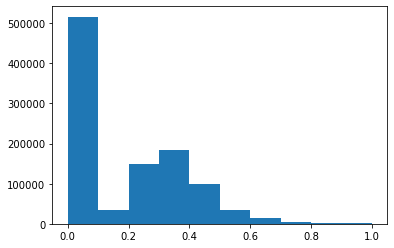

In [4]:
che=cv2.resize(np.array(pd.read_csv(alsi_map)),(1440,1438))
che1=cv2.resize(np.array(pd.read_csv(casi_map)),(1440,1438))
che2=cv2.resize(np.array(pd.read_csv(fesi_map)),(1440,1438))
che3=cv2.resize(np.array(pd.read_csv(mgsi_map)),(1440,1438))
che4=cv2.resize(np.array(pd.read_csv(ssi_map)),(1440,1438))
img=np.concatenate([np.array(pd.read_csv(mercury_albedo_top)).flatten(),np.array(pd.read_csv(mercury_albedo_bottom)).flatten()]).reshape((1438,1440))
dummy=che+che1+che2+che3+che4
print(np.shape(dummy))
for i in range(np.shape(dummy)[0]):
    for j in range(np.shape(dummy)[1]):
        if che[i][j]==0 or che1[i][j]==0 or che2[i][j]==0 or che3[i][j]==0 or che4[i][j]==0:
            img[i][j]=0

# plt.imshow(img[:719,:])
plt.hist(img[:,719:].flatten(),bins=10)
plt.show()

In [5]:
class dataset_nearby_pixel(Dataset):
    def __init__(self,path_1,path_2,path_3,path_4,path_5,path_6,mode):
        self.path_1=path_1
        self.path_2=path_2
        self.path_3=path_3
        self.path_4=path_4
        self.path_5=path_5
        self.path_6=path_6
        self.mode=mode
        #converting the data to ndarray
        if mode == "Train" or "train":
            self.X_1=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_1)),(1440,1438))[:719,:],ksize=(0,0),sigmaX=9)
            self.X_2=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_2)),(1440,1438))[:719,:],ksize=(0,0),sigmaX=9)
            self.X_3=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_3)),(1440,1438))[:719,:],ksize=(0,0),sigmaX=9)
            self.X_4=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_4)),(1440,1438))[:719,:],ksize=(0,0),sigmaX=9)
            self.X_5=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_5)),(1440,1438))[:719,:],ksize=(0,0),sigmaX=9)
        elif mode == "Test" or "test":
            self.X_1=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_1)),(1440,1438))[719:,:],ksize=(0,0),sigmaX=9)
            self.X_2=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_2)),(1440,1438))[719:,:],ksize=(0,0),sigmaX=9)
            self.X_3=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_3)),(1440,1438))[719:,:],ksize=(0,0),sigmaX=9)
            self.X_4=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_4)),(1440,1438))[719:,:],ksize=(0,0),sigmaX=9)
            self.X_5=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_5)),(1440,1438))[719:,:],ksize=(0,0),sigmaX=9)
        self.X_6=np.array(pd.read_csv(path_6))
        self.X=[]
        self.Y=[]
        n,m=np.shape(self.X_6)[0],np.shape(self.X_6)[1]
        #mask
        # for l in range(n):
        #     for b in range(m):
        #         if self.X_1[l][b]==0 or self.X_2[l][b]==0 or self.X_3[l][b]==0 or self.X_4[l][b]==0 or self.X_5[l][b]==0:
        #             self.X_6[l][b]=0
        for i in range(1,n-1):
            for j in range(1,m-1):
                nearby=[]
                for a in [-1,0,1]:
                    for b in [-1,0,1]:
                        nearby.append(self.X_6[i+a][j+b])
                # if sum(nearby) !=0 and sum([self.X_1[i][j],self.X_2[i][j],self.X_3[i][j],self.X_4[i][j],self.X_5[i][j]])!=0:
                self.X.append(nearby)
                self.Y.append([self.X_1[i][j],self.X_2[i][j],self.X_3[i][j],self.X_4[i][j],self.X_5[i][j]])
        self.X=np.array(self.X)
        self.Y=np.array(self.Y)
    def __len__(self):
        self.filelength=np.shape(self.Y)[0]
        return self.filelength

    def __getitem__(self,idx):
        return torch.from_numpy(self.X[idx]),torch.from_numpy(self.Y[idx])

In [6]:
class dataset_normal(Dataset):
    def __init__(self,path_1,path_2,path_3,path_4,path_5,path_6,mode):
        self.path_1=path_1
        self.path_2=path_2
        self.path_3=path_3
        self.path_4=path_4
        self.path_5=path_5
        self.path_6=path_6
        self.mode=mode
        #converting the data to ndarray
        if mode == "Train" or "train":
            self.X_1=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_1)),(1440,1438))[:719,:],ksize=(0,0),sigmaX=9)
            self.X_2=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_2)),(1440,1438))[:719,:],ksize=(0,0),sigmaX=9)
            self.X_3=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_3)),(1440,1438))[:719,:],ksize=(0,0),sigmaX=9)
            self.X_4=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_4)),(1440,1438))[:719,:],ksize=(0,0),sigmaX=9)
            self.X_5=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_5)),(1440,1438))[:719,:],ksize=(0,0),sigmaX=9)
        elif mode == "Test" or "test":
            self.X_1=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_1)),(1440,1438))[719:,:],ksize=(0,0),sigmaX=9)
            self.X_2=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_2)),(1440,1438))[719:,:],ksize=(0,0),sigmaX=9)
            self.X_3=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_3)),(1440,1438))[719:,:],ksize=(0,0),sigmaX=9)
            self.X_4=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_4)),(1440,1438))[719:,:],ksize=(0,0),sigmaX=9)
            self.X_5=cv2.GaussianBlur(cv2.resize(np.array(pd.read_csv(path_5)),(1440,1438))[719:,:],ksize=(0,0),sigmaX=9)
        self.X_6=np.array(pd.read_csv(path_6))
        self.X=np.array(self.X_6.flatten())
        self.Y=np.stack((self.X_1.flatten(),self.X_2.flatten(),self.X_3.flatten(),self.X_4.flatten(),self.X_5.flatten()),1)  
    def __len__(self):
        self.filelength=np.shape(self.Y)[0]
        return self.filelength

    def __getitem__(self,idx):
        return torch.tensor(self.X[idx]),torch.from_numpy(self.Y[idx])

In [7]:
class model(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(model, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden)
        self.hidden2 = torch.nn.Linear(n_hidden,n_hidden)
        self.hidden3 = torch.nn.Linear(n_hidden,n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)   
        self.dropout = torch.nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.hidden1(x)))
        x = self.dropout(F.relu(self.hidden2(x)))
        x = self.dropout(F.relu(self.hidden3(x)))
        x = self.predict(x)            
        return x

In [8]:
class autoencoder(torch.nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        # Encoder Network
        self.encoder = torch.nn.Sequential(torch.nn.Linear(9,18),
                                     torch.nn.ReLU(True),
                                     torch.nn.Linear(18,36),
                                     torch.nn.ReLU(True),
                                     torch.nn.Linear(36,72))

        # Decoder Network
        self.decoder = torch.nn.Sequential(torch.nn.Linear(72,36),
                                     torch.nn.ReLU(True),
                                     torch.nn.Linear(36,18),
                                     torch.nn.ReLU(True),
                                     torch.nn.Linear(18,9),
                                     torch.nn.ReLU(True),
                                     torch.nn.Linear(9,5),
                                     torch.nn.ReLU(True))
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x

In [19]:
class train():
    def __init__(self,batch_size,epochs,lr,train_val_split,scheduler,net_type,type):
        self.batch_size=batch_size
        self.scheduler=scheduler
        self.epochs=epochs
        self.lr=lr
        self.train_val_split=train_val_split
        self.net_type=net_type
        self.type=type
        if self.type=="nearby":
            self.data=dataset_nearby_pixel(alsi_map,casi_map,fesi_map,mgsi_map,ssi_map,mercury_albedo_top,mode="Train")
            if net_type=="normal":
                self.net=model(n_feature=9, n_hidden=11, n_output=5)
            elif net_type=="autoencoder":
                self.net=autoencoder()
        elif self.type=="normal":
            self.data=dataset_normal(alsi_map,casi_map,fesi_map,mgsi_map,ssi_map,mercury_albedo_top,mode="Train")
            if net_type=="normal":
                self.net=model(n_feature=1, n_hidden=16, n_output=5)
        self.train_data,self.val_data=random_split(self.data,[len(self.data)-int(self.train_val_split*len(self.data)),int(self.train_val_split*len(self.data))],generator=torch.Generator().manual_seed(42))
        self.train_loader=DataLoader(self.train_data,batch_size=self.batch_size,shuffle=True)
        self.val_loader=DataLoader(self.val_data,batch_size=self.batch_size,shuffle=True)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        if self.scheduler==True:
            self.sched=torch.optim.lr_scheduler.ExponentialLR(self.optimizer,gamma=0.7)
        self.loss_func = torch.nn.MSELoss() 
        self.writer = SummaryWriter()
        
    def trainer(self):
        self.net=self.net.train()
        self.net=self.net.cuda()
        for epoch in range(self.epochs):
            for input,gt in self.train_loader:
                input = input.cuda()
                gt = gt.cuda()
                input=torch.reshape(input,(len(input),1))
                output = self.net(input.float())
                loss = self.loss_func(output, gt.float())
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            if self.scheduler == True:
                self.sched.step()
            print('Epoch : {},  train loss : {}'.format(epoch+1,loss.item()))
            with torch.no_grad():
                for input,gt in self.val_loader:
                    input=input.cuda()
                    gt= gt.cuda()
                    input=torch.reshape(input,(len(input),1))
                    val_output = self.net(input.float())
                    val_loss = self.loss_func(val_output,gt.float())
            print('Epoch : {},  val_loss : {}'.format(epoch+1,val_loss.item()))
            self.writer.add_scalar("Loss/train", loss, epoch)
            self.writer.add_scalar("Loss/val", val_loss, epoch)
            if self.scheduler == True:
                self.writer.add_scalar("lr/epoch",self.lr,epoch)
        torch.save(self.net.state_dict(),f"albedo_{self.epochs}_{self.lr}_{self.batch_size}.pth")

In [20]:
train_best_near=train(batch_size=64,epochs=100,lr=0.0001,train_val_split=0.3,scheduler=False,net_type="normal",type="normal")
train_best_near.trainer()

Epoch : 1,  train loss : 0.03133977949619293
Epoch : 1,  val_loss : 0.03870938718318939
Epoch : 2,  train loss : 0.05512449890375137
Epoch : 2,  val_loss : 0.05250141769647598
Epoch : 3,  train loss : 0.051994312554597855
Epoch : 3,  val_loss : 0.043464284390211105
Epoch : 4,  train loss : 0.05054280906915665
Epoch : 4,  val_loss : 0.055228590965270996
Epoch : 5,  train loss : 0.0480491928756237
Epoch : 5,  val_loss : 0.049581825733184814
Epoch : 6,  train loss : 0.040794581174850464
Epoch : 6,  val_loss : 0.07783304899930954
Epoch : 7,  train loss : 0.04052238538861275
Epoch : 7,  val_loss : 0.06566587835550308
Epoch : 8,  train loss : 0.04446837306022644
Epoch : 8,  val_loss : 0.07925110310316086
Epoch : 9,  train loss : 0.08344703167676926
Epoch : 9,  val_loss : 0.04153115674853325
Epoch : 10,  train loss : 0.049902305006980896
Epoch : 10,  val_loss : 0.04501420632004738


KeyboardInterrupt: 